In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import scipy
import pynlo
import pstats
import cProfile
from scipy import constants

In [3]:
from dataclasses import dataclass

@dataclass
class NobleGasData:
    name: str
    beta2: float          # [fs^2/(cm bar)]
    beta3: float          # [fs^3/(cm bar)]
    beta4: float          # [fs^4/(cm bar)]
    n2_at_one_bar: float  # [m^2/(W bar)]
    
    def __repr__(self):
        return (f"{self.name}: beta2={self.beta2} fs^2/(cm bar), "
                f"beta3={self.beta3} fs^3/(cm bar), "
                f"beta4={self.beta4} fs^4/(cm bar), "
                f"n2_at_one_bar={self.n2_at_one_bar} m^2/(W bar)")

noble_gases = [
    NobleGasData(name="Neon", beta2=0.0202, beta3=0.0158, beta4=0, n2_at_one_bar=0.14e-23),
    NobleGasData(name="Argon", beta2=0.1980, beta3=0.1586, beta4=0, n2_at_one_bar=1.74e-23),
    NobleGasData(name="Krypton", beta2=0.3996, beta3=0.3298, beta4=0, n2_at_one_bar=4.03e-23),
    NobleGasData(name="Xenon", beta2=0.9113, beta3=0.7836, beta4=0, n2_at_one_bar=11.15e-23),
]

In [4]:
def loadGasParameters(gas_name):
    
        noble_gases_dict = {gas.name.lower(): gas for gas in noble_gases}
        gas = noble_gases_dict.get(gas_name.lower(), "Gas data not found.")
    
        n2_at_one_bar = gas.n2_at_one_bar
        beta2 = gas.beta2 * (1e-3)**2 / 1e-5  # [ps^2/(km bar)]
        beta3 = gas.beta3 * (1e-3)**3 / 1e-5  # [ps^3/(km bar)]
        beta4 = gas.beta4 * (1e-3)**4 / 1e-5  # [ps^4/(km bar)]
        betas_at_one_bar = [beta2, beta3, beta4]
        
        return n2_at_one_bar, betas_at_one_bar    

In [5]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False, pressure_in_Torr=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
        self.pressure_in_Torr = pressure_in_Torr

    
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar
    
    def pressureDistribution(self, z=None):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        if self.differential_pumping:
            if self.pressure_in_Torr:
                pressure_entr = self.torrToBar(self.pressure_entr)
                pressure_exit = self.torrToBar(self.pressure_exit)
            else:
                pressure_entr = self.pressure_entr
                pressure_exit = self.pressure_exit
            
            pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        else:
            if self.pressure_in_Torr:
                pressure_dist = self.torrToBar(self.const_pressure)
            else:
                pressure_dist = self.const_pressure

        return pressure_dist
    
    def dispersionFunction(self, z=None):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """

        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
            
        betas = [beta * (1/1e3) * pressure_dist for beta in self.betas_at_one_bar]
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
        
        n2 = pressure_dist * self.n2_at_one_bar
        
        return n2
    
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        
        if self.differential_pumping:
            n2 = self.nonlinearIndexN2(z)
        else:
            n2 = self.nonlinearIndexN2()
            
        Gamma = (n2*w0) / (constants.c*A_eff)
        
        return Gamma


In [6]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar * w = h * v
    E[eV] = E[J] / e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * pulse.F_mks / constants.e
    
    return W_eV

In [7]:
def dB(num):
    return 10 * np.log10(np.abs(num)**2)

In [8]:
def calc_FWHM(pulse):
    
    t = pulse.T_mks
    temporal_intensity = np.abs(pulse.AT)**2
    normalized_temporal_intensity = temporal_intensity / np.max(temporal_intensity)
    
    FWHM_filter = np.where(normalized_temporal_intensity >= 0.5)[0]
    
    if len(FWHM_filter) >= 2:
        FWHM_mks = t[FWHM_filter[-1]] - t[FWHM_filter[0]]
        return FWHM_mks
    else:
        print("Pulse does not have a well-defined FWHM.")

In [9]:
def super_gaussian(x, x0, w, n):
    """
    Generates a super Gaussian distribution.

    Input(s):
    x: the input array over which the super Gaussian function is evaluated
    x0: the center of the super Gaussian peak
    w: the width of the super Gaussian, controlling the spread of the function
    n: the order of the super Gaussian (2 is a Gaussian, higher values create a flatter top and sharper edges)
    Output(s):
    super_gaussian: a super Gaussian distribution
    """
    
    super_gaussian = np.exp(- ((x-x0)/w) ** n)
    return super_gaussian

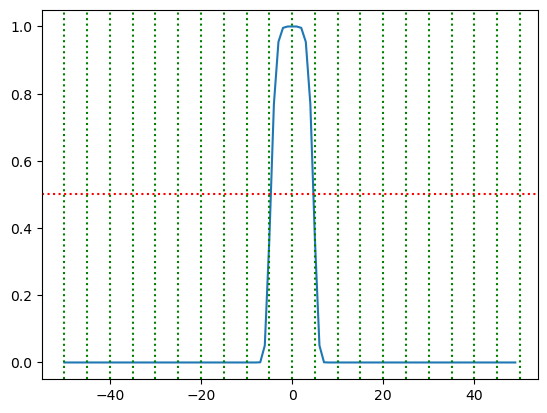

In [10]:
super_gaussian_grid = np.arange(-50,50,1)
plt.figure()
plt.plot(super_gaussian_grid, super_gaussian(super_gaussian_grid, 0, 5, 6))
verticals = [5 * i for i in np.arange(-10,11,1)]
for vertical in verticals:
 plt.axvline(x=vertical, color='g', linestyle=':')
plt.axhline(y=0.5, color='r', linestyle=':')
plt.show()

In [11]:
def general_4by4_plot(pulse_reference, pulse_in, pulse_out, AW, AT, fiber_length):
    """
    Plots spectral and temporal intensities for input and output pulses along with heat maps of AW and AT.

    Input(s):
    pulse_reference: pulse reference object
    pulse_in: input pulse object
    pulse_out: output pulse object
    AW: 2D array of dimensions [frequencies, steps]
    AT: 2D array of dimensions [time, steps]
    fiber_length: length of the fiber
    """
    
    fig = plt.figure(figsize=(15,10))
    ax0 = plt.subplot2grid((2,2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((2,2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((2,2), (1, 0), rowspan=1, sharex=ax0)
    ax3 = plt.subplot2grid((2,2), (1, 1), rowspan=1, sharex=ax1)
    
    Length = fiber_length
    W_eV = photonEnergyGrid(pulse_reference)

    zW = dB(np.transpose(AW)[:, (W_eV > 0)])
    zT = dB(np.transpose(AT))

    spectral_intensity_out = np.abs(np.transpose(pulse_out.AW)[(W_eV > 0)])**2
    temporal_intensity_out = np.abs(np.transpose(pulse_out.AT))**2

    spectral_intensity_in = np.abs(np.transpose(pulse_in.AW)[(W_eV > 0)])**2
    temporal_intensity_in = np.abs(np.transpose(pulse_in.AT))**2

    ax0.plot(W_eV[W_eV > 0], spectral_intensity_out, color='r', linestyle='solid', label='Spectral intensity of output pulse')
    ax0.plot(W_eV[W_eV > 0], spectral_intensity_in, color='b', linestyle='dashed', label='Spectral intensity of input pulse')

    ax1.plot(pulse_out.T_ps, temporal_intensity_out, color='r', label='Temporal intensity of output pulse')
    ax1.plot(pulse_in.T_ps, temporal_intensity_in, color='b', label='Temporal intensity of input pulse')

    extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
    ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                     vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')
    
    extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), 0, Length)
    ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
               vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')
    
    ax0.legend()
    ax0.set_yscale('log')
    ax0.set_ylabel('Spectral power density (W/eV)')
    
    ax1.legend()
    ax2.set_xlabel('Photon energy (eV)')
    ax3.set_xlabel('Time (ps)')
    
    ax2.set_xlim(0, 18.5)
    ax2.set_ylabel('Propagation distance (mm)')

    HHGs = [1.55 * (i + 1) for i in range(11)]
    for HHG in HHGs:
        ax0.axvline(x=HHG, color='g', linestyle=':')

    plt.tight_layout()
    plt.show()

Energy division is:

$\eta_{SHG} = \frac{E_{2\omega}}{E_\omega} = 0.2$ leads to $5E_{2\omega} = E_\omega$

$E_\omega + E_{2\omega} = E_{\omega}^{(0)}$ gives $\frac{6}{5}E_\omega = E_{\omega}^{(0)}$

Hence, we obtain $E_\omega = \frac{5}{6} E_{\omega}^{(0)}$ and $E_{2\omega} = \frac{1}{6} E_{\omega}^{(0)}$

More generally, $ E_{2\omega} = \eta_{SHG} E_\omega $

$(1+\eta_{SHG}) E_\omega = E_{\omega}^{(0)}$

$E_\omega = \frac{1}{1+\eta_{SHG}} E_{\omega}^{(0)}$

$E_{2\omega} = \frac{\eta_{SHG}}{1+\eta_{SHG}} E_{\omega}^{(0)}$

For a given pulse duration and fiber radius (cross section), and a given energy, can calculate intensity that can be achieved:

$I = \frac{energy}{time \times area}$

For a given laser device, thus a given duration, the maximum energy per pulse is usually limited:
1. for a given fiber radius, this gives the maximum achievable intensity
2. for a given desired intensity to be achieved, this gives the fiber radius


In [12]:
class PeakIntensityBuilder:
    
    def __init__(self, SHG_efficiency, pulse_duration, peak_intensity_CGS=None):
        
        self.eta = SHG_efficiency
        self.FWHM = pulse_duration                                # [s]
        self.peak_intensity_CGS = peak_intensity_CGS              # [W/cm^2]
        self.peak_intensity_MKS = self.toMKS(peak_intensity_CGS)  # [W/m^2]
    
    def toMKS(self, intensity_CGS):
        """
        Unit conversion for optical intensity from W/cm^2 to W/m^2.
        
        Input(s):
        intensity_CGS: intensity [W/cm^2]
        Output(s):
        intensity_MKS: intensity [W/m^2]
        """
        intensity_MKS = intensity_CGS / (1e-2)**2
        return intensity_MKS
    
    def toCGS(self, intensity_MKS):
        """
        Unit conversion for optical intensity from W/m^2 to W/cm^2.
        
        Input(s):
        intensity_MKS: intensity [W/m^2]
        Output(s):
        intensity_CGS: intensity [W/cm^2]
        """
        intensity_CGS = intensity_MKS / (1e2)**2
        return intensity_CGS
    
    def divideEPP(self, total_EPP):
        EPP_FD = total_EPP / (1 + self.eta)
        EPP_SH = self.eta * EPP_FD
        return EPP_FD, EPP_SH
    
    def calcFiberRadius(self, total_EPP_limit):
        """
        Calculate the maximum fiber radius in [m] that maintains the required peak intensity
        for a given pulse energy and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_FD_limit, EPP_SH_limit = self.divideEPP(total_EPP_limit)
        fiber_rad_limit = np.sqrt(EPP_SH_limit / (self.peak_intensity_MKS * self.FWHM * np.pi))
        return fiber_rad_limit
    
    def calcPeakIntensity(self, reference_EPP, fiber_radius):
        """
        Calculate the resulting peak intensity in [W/cm^2] from the given pulse energy,
        pulse duration and fiber radius.
        """
        peak_intensity_MKS = reference_EPP / (self.FWHM * np.pi * fiber_radius**2)
        peak_intensity_CGS = self.toCGS(peak_intensity_MKS)
        return peak_intensity_CGS
    
    def calcEPP(self, fiber_radius):
        """
        Calculate the pulse energies in [J] that maintain the required peak intensity
        for a given fiber radius and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_SH = self.peak_intensity_MKS * self.FWHM * np.pi * fiber_radius**2
        EPP_FD = EPP_SH / self.eta
        total_EPP = EPP_FD + EPP_SH
        return total_EPP, EPP_FD, EPP_SH
        

### Test for UVC plot:

In [13]:
# pulse parameters
FWHM = 0.03                # pulse duration [ps]
pulseWL = 800              # pulse central wavelength [nm]
SHG_efficiency = 0.2       # SHG conversion efficiency
total_EPP_limit = 1e-3     # pulse energy limit of laser source [J]
GDD = 0.0                  # group delay dispersion [ps^2]
TOD = 0.0                  # third order dispersion [ps^3]
peak_intensity_CGS = 2e12  # peak intensity for nonlinear processes [W/cm^2]

# fiber parameters
Length = 600             # fiber length [mm]
fiber_rad = np.array([127e-6])             # fiber radius [m]
fibWL = pulseWL                            # center wavelength of fiber [nm]
Alpha = 0.0                                # attentuation coefficient [dB/cm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# simulation parameters
Window = 2        # simulation window [ps]
Steps = Length        # simulation steps
Points = 2**14    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?


In [14]:
intensitybuilder = PeakIntensityBuilder(SHG_efficiency=SHG_efficiency, 
                                        pulse_duration=FWHM*1e-12, 
                                        peak_intensity_CGS=peak_intensity_CGS)

# calculate the upper limit on the fiber radius for given total EPP available
fiber_rad_limit = intensitybuilder.calcFiberRadius(total_EPP_limit=total_EPP_limit)
print(f'If a total pulse energy of {total_EPP_limit*1e3} mJ is available, the maximum possible fiber radius is {fiber_rad_limit*1e6:.4} microns.')

# energy division
total_EPP, EPP_FD, EPP_SH = intensitybuilder.calcEPP(fiber_radius=fiber_rad)
for i in range(len(fiber_rad)):
    print(f'For fiber radius {fiber_rad[i]*1e6:.4} microns, a total of {total_EPP[i]*1e3:.4} mJ is needed, of which the fundamental pulse has {EPP_FD[i]*1e3:.4} mJ, the second harmonic pulse has {EPP_SH[i]*1e3:.4} mJ.')

# load gas parameters
n2_at_one_bar, betas_at_one_bar = loadGasParameters("Xenon")

If a total pulse energy of 1.0 mJ is available, the maximum possible fiber radius is 297.4 microns.
For fiber radius 127.0 microns, a total of 0.1824 mJ is needed, of which the fundamental pulse has 0.152 mJ, the second harmonic pulse has 0.0304 mJ.


In [16]:
def nm_to_Hz(wavelength_nm):

    frequency_Hz = constants.c / (wavelength_nm * 1e-9)
    return frequency_Hz
    
def frequency_spacing_Hz(wavelength_spacing_nm, center_wavelength_nm):
    
    frequency_spacing_Hz = constants.c * wavelength_spacing_nm * 1e-9 / (center_wavelength_nm * 1e-9)**2
    return frequency_spacing_Hz

In [19]:
third_harmonic_energy_data = []
third_harmonic_peak_power_data = []
fourth_harmonic_energy_data = []
fourth_harmonic_peak_power_data = []

# gas pressure [bar]
pressures = np.linspace(1,1000,1000) * 1e-3

for pressure in pressures:

    # build the gas properties, static field
    gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, fiber_radius=fiber_rad[0], pulse_wavelength=pulseWL, 
                                    betas_at_one_bar=betas_at_one_bar, constant_pressure=pressure, pressure_boundary=None, 
                                    n2_at_one_bar=n2_at_one_bar, differential_pumping=False, pressure_in_Torr=False)
    
    # create the fiber
    fiber = pynlo.media.fibers.fiber.FiberInstance()
    fiber.generate_fiber(Length*1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(), 
                         gamma_W_m=gasbuilder.gammaDistribution(), gvd_units='ps^n/m', gain=-alpha)

    # create the fundamental pulse
    pulse_FD = pynlo.light.DerivedPulses.SechPulse(
        1, FWHM/1.76, pulseWL, time_window_ps=Window,
        GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1e-3, power_is_avg=True
    )
    pulse_FD = pulse_FD.interpolate_to_new_center_wl(pulseWL/3)
    pulse_FD.set_epp(EPP_FD[0])
    
    # create the second harmonic pulse
    pulse_SH = pynlo.light.DerivedPulses.SechPulse(
        1, FWHM/1.76, pulseWL/2, time_window_ps=Window,
        GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1e-3, power_is_avg=True
    )
    pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL/3)
    pulse_SH.set_epp(EPP_SH[0])
    
    # create the combined pulse
    pulse = pynlo.light.PulseBase.Pulse()
    pulse.set_NPTS(Points)
    pulse.set_time_window_ps(Window)
    pulse.set_frep_MHz(1e-3)
    pulse.set_center_wavelength_nm(fibWL)
    pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

    # propagation
    evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True, 
                                                       disable_Raman=np.logical_not(Raman), 
                                                       disable_self_steepening=np.logical_not(Steep))

    print(f"Run for {pressure}bar and {Length}mm.")
    # using static field
    y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=Steps, reload_fiber_each_step=False)    
    print(f"Run for {pressure}bar and {Length}mm has ended.")

    W_eV = photonEnergyGrid(pulse_FD)
    
    mask_center_third_harmonic = pulseWL/3                             # center frequency of the mask [nm]
    mask_width_third_harmonic = 15                                     # width of the mask [nm] 4
    mask_order_third_harmonic = 6                                      # order of the super Gaussian (2 is a Gaussian, higher values create a flatter top) 4

    mask_center_fourth_harmonic = pulseWL/4                            # center wavelength of the mask [nm]
    mask_width_fourth_harmonic = 15                                    # width of the mask [nm] 2.5
    mask_order_fourth_harmonic = 6                                    # order of the super Gaussian (2 is a Gaussian, higher values create a flatter top) 4

    # create the super Gaussian masks
    mask_third_harmonic = super_gaussian(pulse_FD.wl_nm, mask_center_third_harmonic, mask_width_third_harmonic, mask_order_third_harmonic)
    mask_fourth_harmonic = super_gaussian(pulse_FD.wl_nm, mask_center_fourth_harmonic, mask_width_fourth_harmonic, mask_order_fourth_harmonic)
    
    for step in range(1, Steps):
        
        # create the third harmonic pulse
        third_harmonic_pulse = pynlo.light.PulseBase.Pulse()
        third_harmonic_pulse.set_NPTS(Points)
        third_harmonic_pulse.set_time_window_ps(Window)
        third_harmonic_pulse.set_frep_MHz(1e-3)
        third_harmonic_pulse.set_center_wavelength_nm(pulseWL/3)
        third_harmonic_pulse.set_AW(AW[:,step] * mask_third_harmonic)
        
        # third_harmonic_spectral_power = np.abs(third_harmonic_pulse.AW[W_eV > 0])**2
        third_harmonic_energy = third_harmonic_pulse.calc_epp()
        third_harmonic_peak_power = third_harmonic_energy / calc_FWHM(third_harmonic_pulse)

        # append the truncated data
        third_harmonic_energy_data.append({
            'gas pressure': pressure,
            'fiber length': step,
            'third harmonic energy': third_harmonic_energy
        })
        third_harmonic_peak_power_data.append({
            'gas pressure': pressure,
            'fiber length': step,
            'third harmonic peak power': third_harmonic_peak_power
        })

        # create the fourth harmonic pulse
        fourth_harmonic_pulse = pynlo.light.PulseBase.Pulse()
        fourth_harmonic_pulse.set_NPTS(Points)
        fourth_harmonic_pulse.set_time_window_ps(Window)
        fourth_harmonic_pulse.set_frep_MHz(1e-3)
        fourth_harmonic_pulse.set_center_wavelength_nm(pulseWL/4)
        fourth_harmonic_pulse.set_AW(AW[:,step] * mask_fourth_harmonic)
        
        # fourth_harmonic_spectral_power = np.abs(fourth_harmonic_pulse.AW[W_eV > 0])**2
        fourth_harmonic_energy = fourth_harmonic_pulse.calc_epp()
        fourth_harmonic_peak_power = fourth_harmonic_energy / calc_FWHM(fourth_harmonic_pulse)

        fourth_harmonic_energy_data.append({
            'gas pressure': pressure,
            'fiber length': step,
            'fourth harmonic energy': fourth_harmonic_energy
        })
        fourth_harmonic_peak_power_data.append({
            'gas pressure': pressure,
            'fiber length': step,
            'fourth harmonic peak power': fourth_harmonic_peak_power
        })

    # create the truncated third harmonic pulse
    third_harmonic_pulse = pynlo.light.PulseBase.Pulse()
    third_harmonic_pulse.set_NPTS(Points)
    third_harmonic_pulse.set_time_window_ps(Window)
    third_harmonic_pulse.set_frep_MHz(1e-3)
    third_harmonic_pulse.set_center_wavelength_nm(pulseWL/3)
    third_harmonic_pulse.set_AW(pulse_out.AW * mask_third_harmonic)

    third_harmonic_spectral_power = np.abs(third_harmonic_pulse.AW[W_eV > 0])**2
    third_harmonic_energy = third_harmonic_pulse.calc_epp()
    third_harmonic_peak_power = third_harmonic_energy / calc_FWHM(third_harmonic_pulse)

    # append the truncated data
    third_harmonic_energy_data.append({
        'gas pressure': pressure,
        'fiber length': Length,
        'third harmonic energy': third_harmonic_energy
    })
    third_harmonic_peak_power_data.append({
        'gas pressure': pressure,
        'fiber length': Length,
        'third harmonic peak power': third_harmonic_peak_power
    })

    # create the truncated fourth harmonic pulse
    fourth_harmonic_pulse = pynlo.light.PulseBase.Pulse()
    fourth_harmonic_pulse.set_NPTS(Points)
    fourth_harmonic_pulse.set_time_window_ps(Window)
    fourth_harmonic_pulse.set_frep_MHz(1e-3)
    fourth_harmonic_pulse.set_center_wavelength_nm(pulseWL/4)
    fourth_harmonic_pulse.set_AW(pulse_out.AW * mask_fourth_harmonic)

    fourth_harmonic_spectral_power = np.abs(fourth_harmonic_pulse.AW[W_eV > 0])**2
    fourth_harmonic_energy = fourth_harmonic_pulse.calc_epp()
    fourth_harmonic_peak_power = fourth_harmonic_energy / calc_FWHM(fourth_harmonic_pulse)

    fourth_harmonic_energy_data.append({
        'gas pressure': pressure,
        'fiber length': Length,
        'fourth harmonic energy': fourth_harmonic_energy
    })
    fourth_harmonic_peak_power_data.append({
        'gas pressure': pressure,
        'fiber length': Length,
        'fourth harmonic peak power': fourth_harmonic_peak_power
    })
    

Run for 0.001bar and 600mm.
Run for 0.001bar and 600mm has ended.
Run for 0.002bar and 600mm.
Run for 0.002bar and 600mm has ended.
Run for 0.003bar and 600mm.
Run for 0.003bar and 600mm has ended.
Run for 0.004bar and 600mm.
Run for 0.004bar and 600mm has ended.
Run for 0.005bar and 600mm.
Run for 0.005bar and 600mm has ended.
Run for 0.006bar and 600mm.
Run for 0.006bar and 600mm has ended.
Run for 0.007bar and 600mm.
Run for 0.007bar and 600mm has ended.
Run for 0.008bar and 600mm.
Run for 0.008bar and 600mm has ended.
Run for 0.009000000000000001bar and 600mm.
Run for 0.009000000000000001bar and 600mm has ended.
Run for 0.01bar and 600mm.
Run for 0.01bar and 600mm has ended.
Run for 0.011bar and 600mm.
Run for 0.011bar and 600mm has ended.
Run for 0.012bar and 600mm.
Run for 0.012bar and 600mm has ended.
Run for 0.013000000000000001bar and 600mm.
Run for 0.013000000000000001bar and 600mm has ended.
Run for 0.014bar and 600mm.
Run for 0.014bar and 600mm has ended.
Run for 0.015bar a

In [20]:
third_harmonic_energy_dataframe = pd.DataFrame(third_harmonic_energy_data)
third_harmonic_peak_power_dataframe = pd.DataFrame(third_harmonic_peak_power_data)
fourth_harmonic_energy_dataframe = pd.DataFrame(fourth_harmonic_energy_data)
fourth_harmonic_peak_power_dataframe = pd.DataFrame(fourth_harmonic_peak_power_data)

In [21]:
third_harmonic_energy_dataframe.to_csv("third_harmonic_energy_dataframe_v5.csv", index=False)
third_harmonic_peak_power_dataframe.to_csv("third_harmonic_peak_power_dataframe_v5.csv", index=False)
fourth_harmonic_energy_dataframe.to_csv("fourth_harmonic_energy_dataframe_v5.csv", index=False)
fourth_harmonic_peak_power_dataframe.to_csv("fourth_harmonic_peak_power_dataframe_v5.csv", index=False)

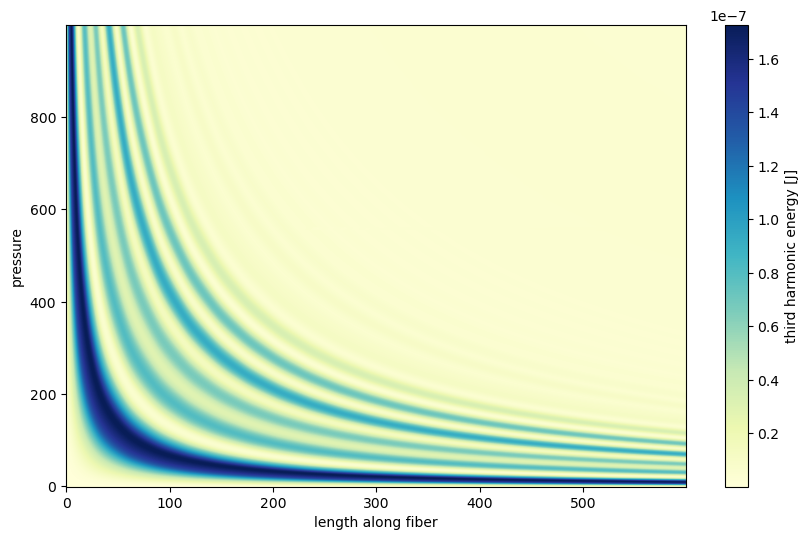

The maximum energy conversion efficiency (for third harmonic) is [0.09468295]% at pressure 0.169bar and length 40.0mm.


In [37]:
heatmap1 = third_harmonic_energy_dataframe.pivot(index='gas pressure', columns='fiber length', values='third harmonic energy')

plt.figure(figsize=(10, 6))
plt.imshow(heatmap1, aspect='auto', cmap='YlGnBu', origin='lower')
plt.colorbar(label='third harmonic energy [J]')
plt.xlabel('length along fiber')
plt.ylabel('pressure')
plt.show()

max_energy_row = third_harmonic_energy_dataframe.loc[third_harmonic_energy_dataframe['third harmonic energy'].idxmax()]

max_energy = max_energy_row['third harmonic energy']
corresponding_gas_pressure = max_energy_row['gas pressure']
corresponding_fiber_length = max_energy_row['fiber length']

print(f"The maximum energy conversion efficiency (for third harmonic) is {(max_energy/total_EPP)*100}% at pressure {corresponding_gas_pressure}bar and length {corresponding_fiber_length}mm.")


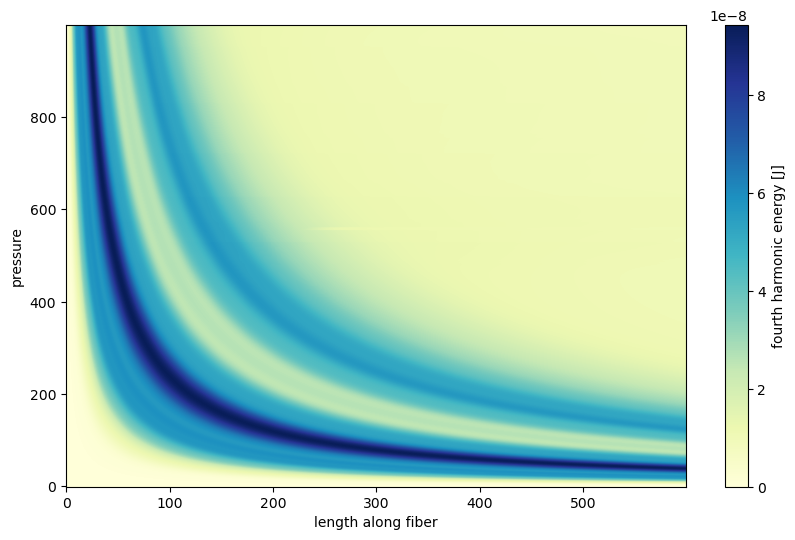

In [23]:
heatmap2 = fourth_harmonic_energy_dataframe.pivot(index='gas pressure', columns='fiber length', values='fourth harmonic energy')

plt.figure(figsize=(10, 6))
plt.imshow(heatmap2, aspect='auto', cmap='YlGnBu', origin='lower')
plt.colorbar(label='fourth harmonic energy [J]')
plt.xlabel('length along fiber')
plt.ylabel('pressure')
plt.show()

The maximum peak power conversion efficiency (for third harmonic) is [0.1638676]% at pressure 0.136bar and length 50.0mm.


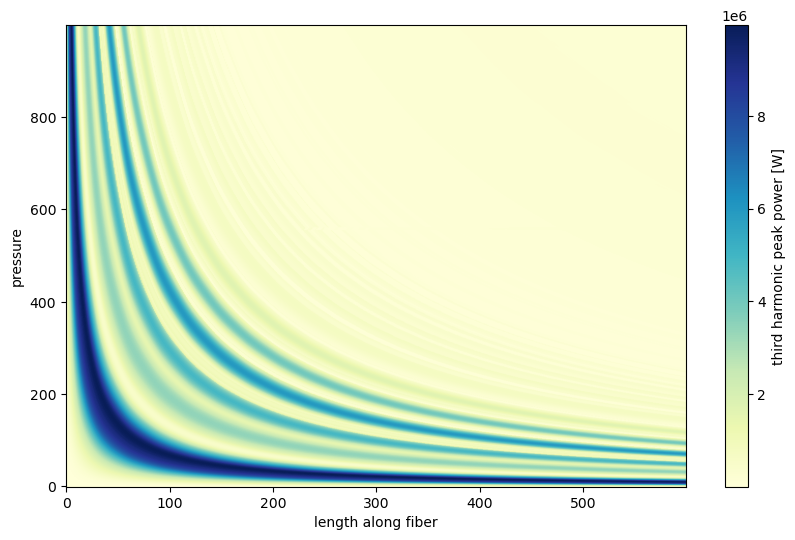

In [38]:
heatmap3 = third_harmonic_peak_power_dataframe.pivot(index='gas pressure', columns='fiber length', values='third harmonic peak power')

plt.figure(figsize=(10, 6))
plt.imshow(heatmap3, aspect='auto', cmap='YlGnBu', origin='lower')
plt.colorbar(label='third harmonic peak power [W]')
plt.xlabel('length along fiber')
plt.ylabel('pressure')
plt.show()

max_peak_power_row = third_harmonic_peak_power_dataframe.loc[third_harmonic_peak_power_dataframe['third harmonic peak power'].idxmax()]

max_peak_power = max_peak_power_row['third harmonic peak power']
corresponding_gas_pressure = max_peak_power_row['gas pressure']
corresponding_fiber_length = max_peak_power_row['fiber length']

print(f"The maximum peak power conversion efficiency (for third harmonic) is {(max_peak_power/(total_EPP/(FWHM*1e-12)))*100}% at pressure {corresponding_gas_pressure}bar and length {corresponding_fiber_length}mm.")


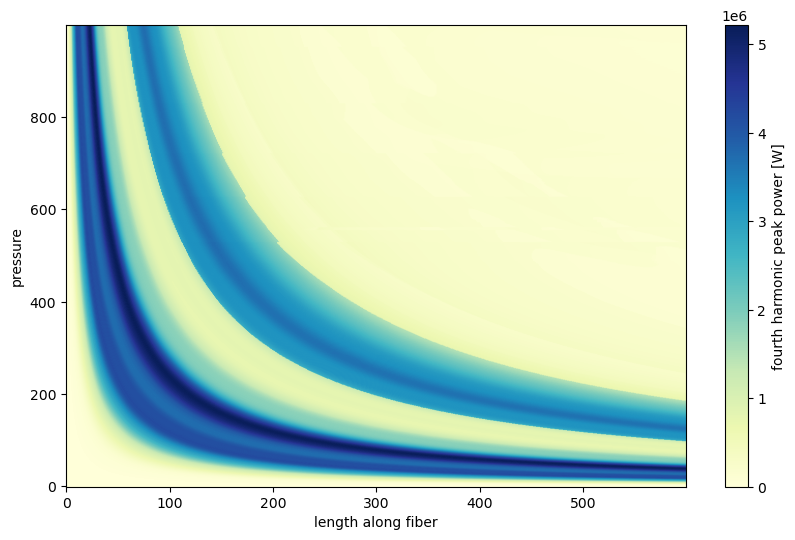

In [27]:
heatmap4 = fourth_harmonic_peak_power_dataframe.pivot(index='gas pressure', columns='fiber length', values='fourth harmonic peak power')

plt.figure(figsize=(10, 6))
plt.imshow(heatmap4, aspect='auto', cmap='YlGnBu', origin='lower')
plt.colorbar(label='fourth harmonic peak power [W]')
plt.xlabel('length along fiber')
plt.ylabel('pressure')
plt.show()

### Data when length is 127mm:

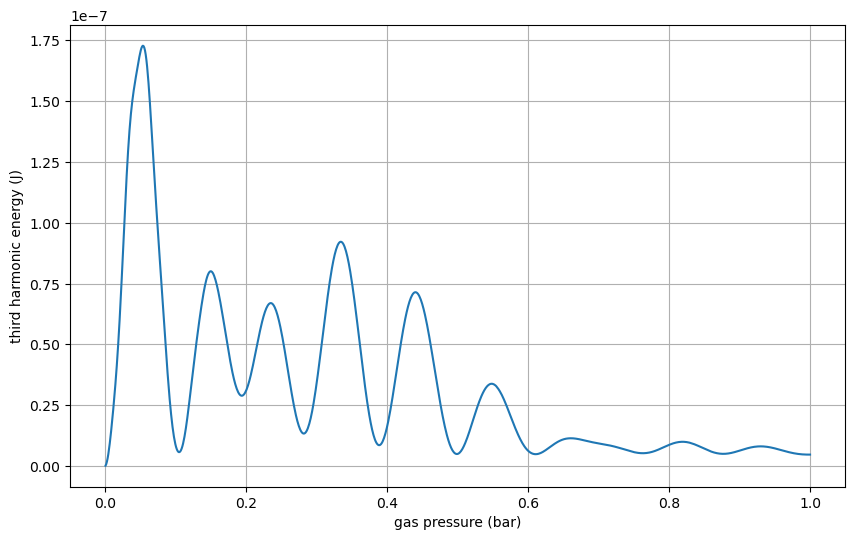

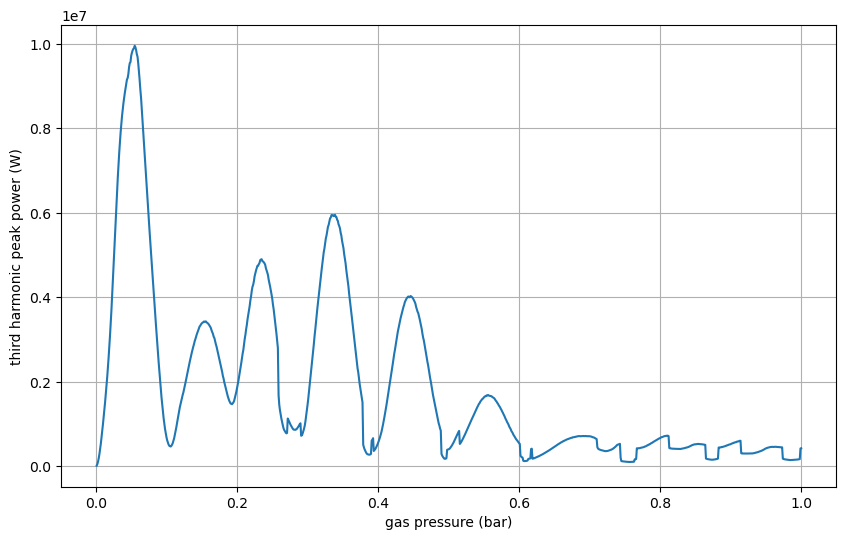

At fiber length 127mm, the maximum energy is 1.7271159670593103e-07J and the corresponding pressure is 0.054bar.
The energy conversion efficiency is [0.09468075]% and the peak power efficiency is [0.16370686]%


In [34]:
specific_fiber_length = 127

filtered_third_harmonic_energy = third_harmonic_energy_dataframe[third_harmonic_energy_dataframe['fiber length'] == specific_fiber_length]
filtered_third_harmonic_peak_power = third_harmonic_peak_power_dataframe[third_harmonic_peak_power_dataframe['fiber length'] == specific_fiber_length]

gas_pressures = filtered_third_harmonic_peak_power['gas pressure']
third_harmonic_energies = filtered_third_harmonic_energy['third harmonic energy']
third_harmonic_peak_powers = filtered_third_harmonic_peak_power['third harmonic peak power']

plt.figure(figsize=(10, 6))
plt.plot(gas_pressures, third_harmonic_energies)
plt.xlabel('gas pressure (bar)')
plt.ylabel('third harmonic energy (J)')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(gas_pressures, third_harmonic_peak_powers)
plt.xlabel('gas pressure (bar)')
plt.ylabel('third harmonic peak power (W)')
plt.grid(True)
plt.show()

max_energy_row = filtered_third_harmonic_energy.loc[filtered_third_harmonic_energy['third harmonic energy'].idxmax()]
max_peak_power_row = filtered_third_harmonic_peak_power.loc[filtered_third_harmonic_peak_power['third harmonic peak power'].idxmax()]

max_energy = max_energy_row['third harmonic energy']
corresponding_gas_pressure = max_energy_row['gas pressure']

max_peak_power = max_peak_power_row['third harmonic peak power']

print(f"At fiber length {specific_fiber_length}mm, the maximum energy is {max_energy}J and the corresponding pressure is {corresponding_gas_pressure}bar.")
print(f"The energy conversion efficiency is {(max_energy/total_EPP)*100}% and the peak power efficiency is {(max_peak_power/(total_EPP/(FWHM*1e-12)))*100}%")


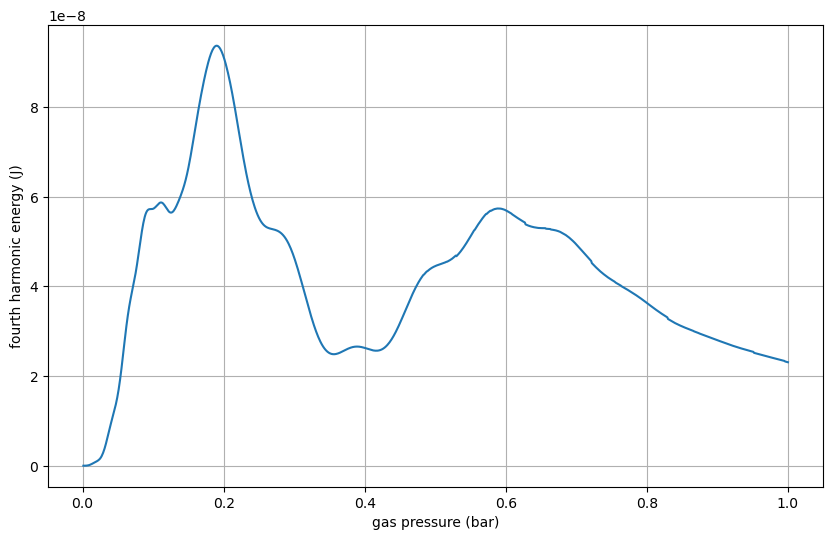

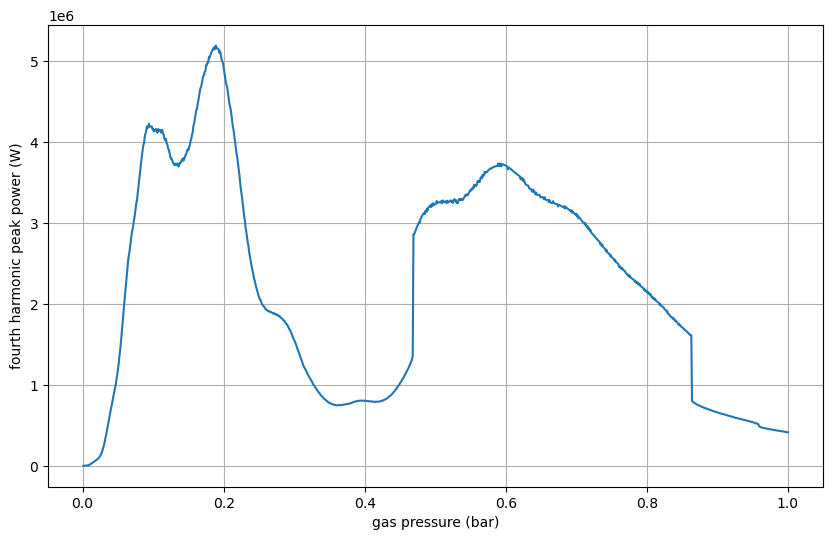

At fiber length 127mm, the maximum energy is 9.371527112087089e-08J and the corresponding pressure is 0.19bar.


In [33]:
filtered_fourth_harmonic_energy = fourth_harmonic_energy_dataframe[fourth_harmonic_energy_dataframe['fiber length'] == specific_fiber_length]
filtered_fourth_harmonic_peak_power = fourth_harmonic_peak_power_dataframe[fourth_harmonic_peak_power_dataframe['fiber length'] == specific_fiber_length]

gas_pressures = filtered_fourth_harmonic_peak_power['gas pressure']
fourth_harmonic_energies = filtered_fourth_harmonic_energy['fourth harmonic energy']
fourth_harmonic_peak_powers = filtered_fourth_harmonic_peak_power['fourth harmonic peak power']

plt.figure(figsize=(10, 6))
plt.plot(gas_pressures, fourth_harmonic_energies)
plt.xlabel('gas pressure (bar)')
plt.ylabel('fourth harmonic energy (J)')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(gas_pressures, fourth_harmonic_peak_powers)
plt.xlabel('gas pressure (bar)')
plt.ylabel('fourth harmonic peak power (W)')
plt.grid(True)
plt.show()

# find the row with the maximum peak power
max_energy_row = filtered_fourth_harmonic_energy.loc[filtered_fourth_harmonic_energy['fourth harmonic energy'].idxmax()]

# Extract the maximum peak power and corresponding gas pressure
max_energy = max_energy_row['fourth harmonic energy']
corresponding_gas_pressure = max_energy_row['gas pressure']

print(f"At fiber length {specific_fiber_length}mm, the maximum energy is {max_energy}J and the corresponding pressure is {corresponding_gas_pressure}bar.")